# Moonshot 月度因子回测框架教程

Moonhot 是一个用于月度调仓的策略回测框架。它有以下特点：

1. 行情数据和因子数据可以是日线，框架自动转换成为月线。
2. 基准收益使用买入并持有法进行计算。
3. 计算策略收益时，如果个股是当月新调入，则以月开盘价作为买入价格，月收盘作为卖出价格。如果是连续持有，则以上月收盘价作为买入价格，月收盘作为卖出价格，避免无谓的调仓损失。
4. 支持多因子策略（见演示），也支持单因子回测
5. 使用 quantstats 进行策略评估，以保证评估与主流框架的一致性。
6. 核心模块单元测试覆盖率接近100%。

Moonshot 的使用方法很简单：
1. 传入日线行情，实例化 Moonshot 对象`ms`
2. 调用 `ms.append_factor`方法，添加因子数据（或者称信号）。因子数据可以是离散的，也可以是连续的。如果是离散的，要求取值为[-1, 0, 1]，表明调仓方向；如果是连续的，则需要指定因子分层数，框架将使用 top 分层做多，同时对bottom 分层做空（如果是多空策略）
3. 调用`ms.report`方法，生成回测报告。

本教程将演示如何使用Moonshot进行月度因子回测分析。我们将从最简单的示例开始，逐步展示更复杂的功能。

## 1. 快速开始

现在，我们将生成一段合成数据，快速演示 moonshot 的使用方法。

首先，我们导入必要的库。

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from moonshot import Moonshot
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.unicode_minus'] = False

print("Moonshot imported successfully！")

Moonshot imported successfully！


现在，我们来生成一些合成数据。

asset
A    Axes(0.125,0.11;0.775x0.77)
B    Axes(0.125,0.11;0.775x0.77)
C    Axes(0.125,0.11;0.775x0.77)
D    Axes(0.125,0.11;0.775x0.77)
E    Axes(0.125,0.11;0.775x0.77)
Name: close, dtype: object

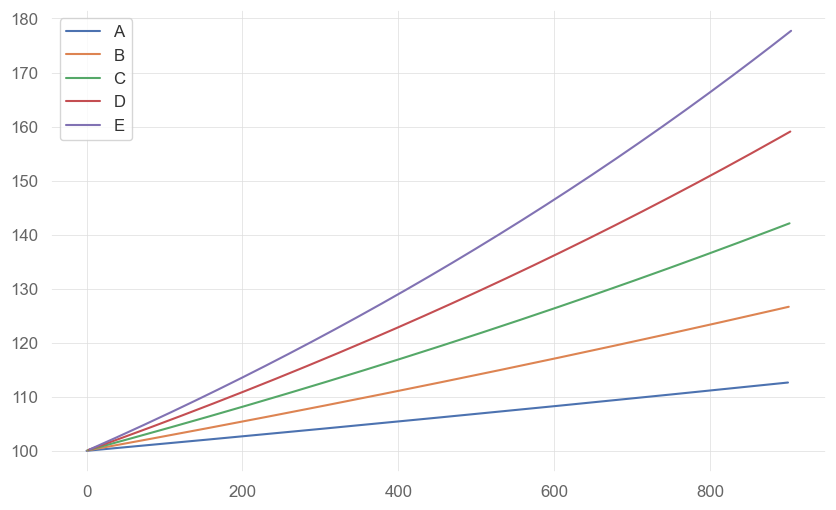

In [2]:
from operator import le


dates = pd.date_range("2023-01-01", "2023-06-30", freq="D")
assets = ["A", "B", "C", "D", "E"]

# Generate price data with returns correlated to factor
price_data = []
base_returns = [0.02, 0.04, 0.06, 0.08, 0.10]  # Higher factor -> higher return

for date in dates:
    for i, asset in enumerate(assets):
        base_price = 100
        monthly_return = base_returns[i]
        days_in_month = 30
        daily_return = (1 + monthly_return) ** (1 / days_in_month) - 1

        price = base_price * (1 + daily_return) ** ((date - dates[0]).days)

        price_data.append(
            {
                "date": date,
                "asset": asset,
                "open": price,
                "close": price * (1 + daily_return),
            }
        )

bars = pd.DataFrame(price_data)
bars.groupby("asset")["close"].plot(legend=True)

现在，我们生成因子数据。

In [3]:
factor_data = []
factor_values = [1.0, 2.0, 3.0, 4.0, 5.0]  # Clear ranking

for month in pd.date_range("2023-01-31", "2023-05-31", freq="ME"):
    for i, asset in enumerate(assets):
        factor_data.append(
            {
                "date": month,
                "asset": asset,
                "factor": factor_values[i],  # Consistent ranking
            }
        )

factors = pd.DataFrame(factor_data)
factors.pivot(index="date", columns="asset", values="factor")

asset,A,B,C,D,E
date,,,,,
2023-01-31,1.0,2.0,3.0,4.0,5.0
2023-02-28,1.0,2.0,3.0,4.0,5.0
2023-03-31,1.0,2.0,3.0,4.0,5.0
2023-04-30,1.0,2.0,3.0,4.0,5.0
2023-05-31,1.0,2.0,3.0,4.0,5.0


因此，在回测时，由于 A 组因子值始终最小，E 组始终最大，所以，单多策略的收益就应该是 E 组的收益，多空策略的收益则是 E-A 的收益除以2。

现在，数据准备完成。我们就实例化 Moonshot，传入价格和因子数据，进行回测。

In [4]:
ms = Moonshot(bars)
ms.append_factor(factors, "factor", resample="last")
returns, benchmark = ms.run()
print(returns)
print(benchmark)

month
2023-01    0.000000
2023-02    0.093033
2023-03    0.103500
2023-04    0.100000
2023-05    0.103500
2023-06    0.100000
Freq: M, Name: 4, dtype: float64
2023-01    0.062074
2023-02    0.055867
2023-03    0.062074
2023-04    0.060000
2023-05    0.062074
2023-06    0.060000
Freq: M, dtype: float64


现在，我们就可以调用 report 来获取报告了。

首先我们可以获取一个基于 dataframe 的报告，通过传入 kind = "metrics"参数。

In [5]:
ms.report(returns, benchmark, kind = "metrics")

                     Benchmark     Strategy
-------------------  ------------  ---------------
Start Period         2023-01-01    2023-01-01
End Period           2023-06-01    2023-06-01
Risk-Free Rate       0.0%          0.0%
Time in Market       84.0%         84.0%

Cumulative Return    33.82%        61.05%
CAGR﹪               20619250.67%  49256537795.24%

Sharpe               32.27         32.26
Prob. Sharpe Ratio   91.6%         91.61%
Sortino              -             -
Sortino/√2           -             -
Omega                -             -

Max Drawdown         %             %
Max DD Date
Max DD Period Start
Max DD Period End
Longest DD Days      -             -

Gain/Pain Ratio      -             -
Gain/Pain (1M)       -             -

Payoff Ratio         -             -
Profit Factor        0.0           0.0
Common Sense Ratio   0.0           0.0
CPC Index            -             -
Tail Ratio           4.44          4.45
Outlier Win Ratio    1.66          0.99
Outlier Los

我们也可以获得一个更漂亮的、基于 html 的报告。这需要传入 kind = "html"参数。其它类型还有 plots, full, basic 等。您可以在 [Quantstats](https://github.com/ranaroussi/quantstats?tab=readme-ov-file#creating-a-report)这里找到所有的报告类型。

不同的类型有时候需要不同的参数，您需要通过 kwargs 来传入。这些参数也请参考 [Quantstats](https://github.com/ranaroussi/quantstats)这里的文档。

In [6]:
ms.report(returns, benchmark, kind = "html", benchmark_title="Moonshot 报告", output="./moonshot.html")


在示例中，我们给出的因子是连续的（是因子，而不是直接的交易、选股信号），因此，我们还可以查看它的分层收益图。

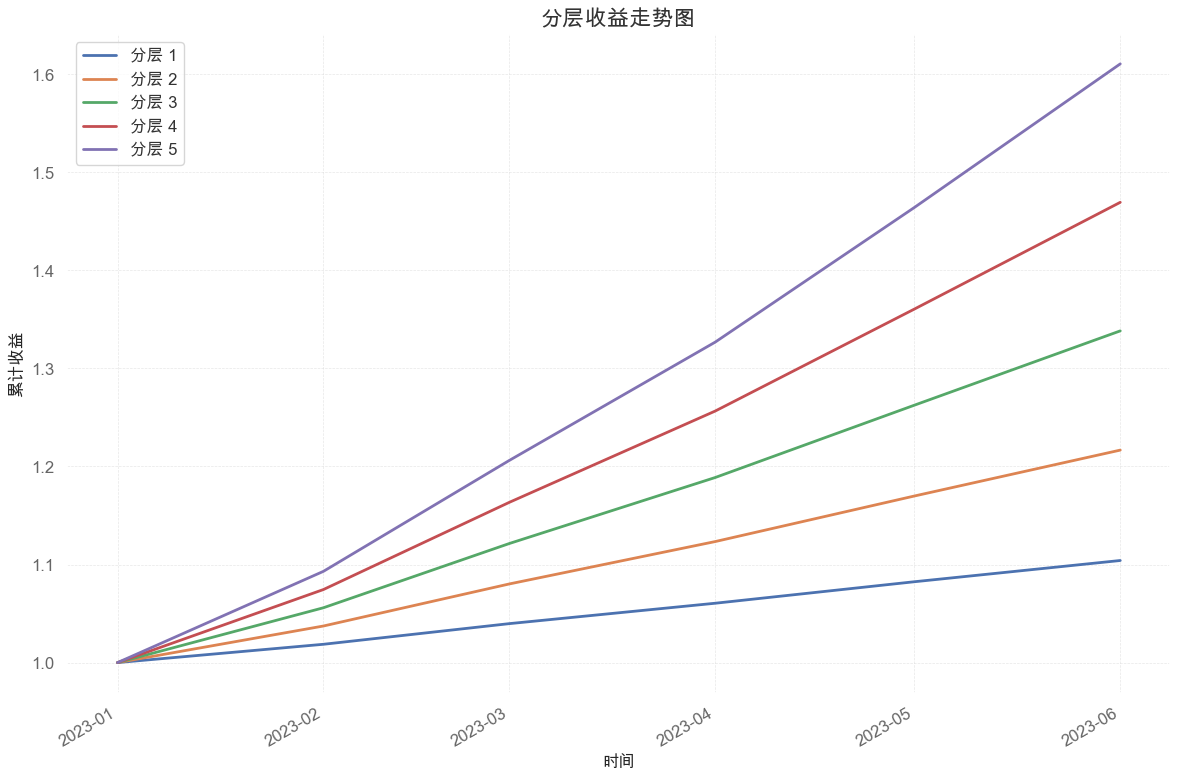

In [7]:
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

ms.plot_quantile_returns()

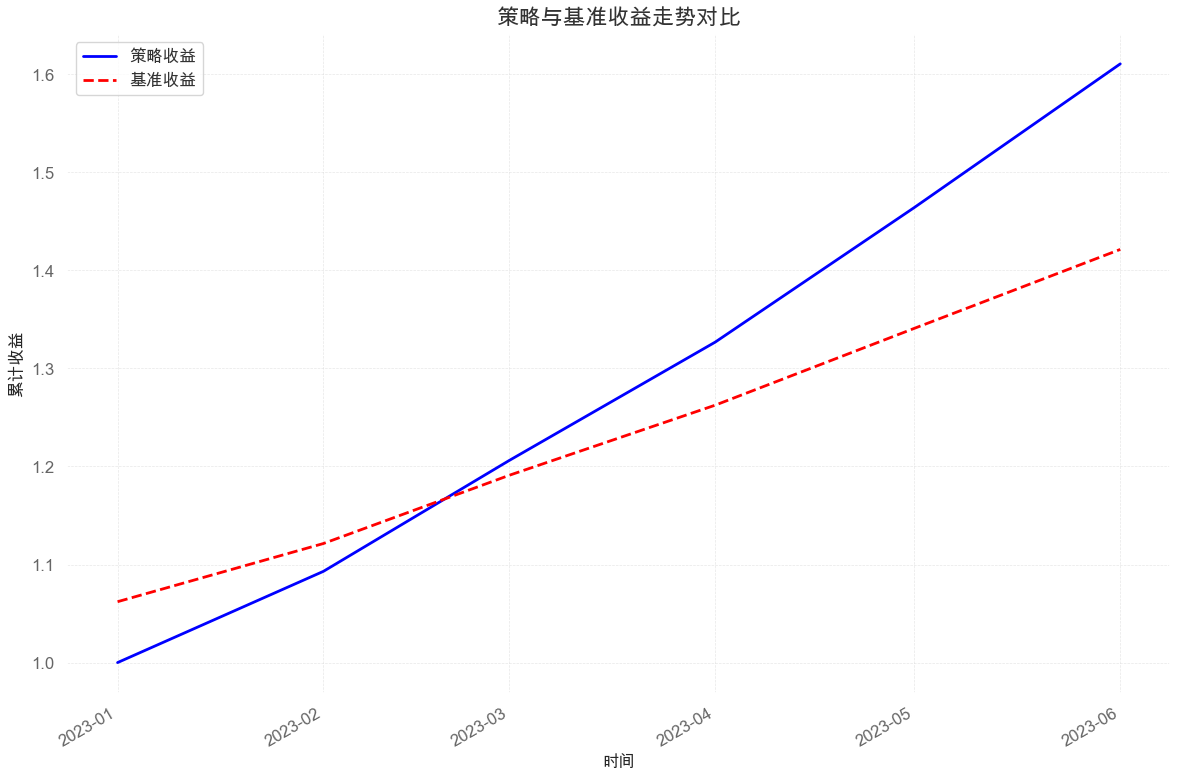

In [8]:
ms.plot_cumulative_returns(returns, benchmark)